# Cleverly Challenge - Part 3

In this notebook we will use TorchText to iterate through the datasets, and create several models to predict helpfulness of reviews

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import itertools
import datetime
import re

import spacy

import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

import pickle

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
path = "data/"

In [5]:
df = pd.read_pickle(os.path.join(path,"df_combined.pkl"))

In [6]:
df.tail()

,reviewTime,overall,word_count,summary,reviewText,reviewerID,reviewerName,year,month,day,dow,reviewYearMonth,word_count_binned,word_count_binned2,combinedText,processedText,target
12355,2014-07-16,4,132,Take caution on sizing,I have found many of the Chinese styles very a...,A18NUOSGFUEBQC,"Hot Cookie ""Yes, Chef!""",2014,7,16,2,2014-07,140,"(-2.881, 130.367]",Take caution on sizing I have found many of th...,take caution on sizing i have found many of th...,0
16005,2014-07-16,5,53,Very cute & fun looking!,"I'm 5'2 and 110lbs I ordered a small, fits gre...",AQ8NV95JJ5PUE,Kristine Termini,2014,7,16,2,2014-07,60,"(-2.881, 130.367]",Very cute & fun looking! I'm 5'2 and 110lbs I ...,very cute fun looking i am and lbs i ordered a...,1
24150,2014-07-16,4,58,Worth the investment!,I have nickel sensitivity and cannot wear prec...,A13KL1NOBZM6DL,stdparty,2014,7,16,2,2014-07,60,"(-2.881, 130.367]",Worth the investment! I have nickel sensitivit...,worth the investment i have nickel sensitivity...,1
34,2014-07-20,1,8,One Star,turn colors after wearing for week,A1O0GKFCQ0OP9I,Patricia Stewart Dailey,2014,7,20,6,2014-07,20,"(-2.881, 130.367]",One Star turn colors after wearing for week,one star turn colors after wearing for week,0
35,2014-07-21,5,9,Gorgeous,Love this blouse and have one in white.,A1L6LRVK79TZ0K,Amazon Customer,2014,7,21,0,2014-07,20,"(-2.881, 130.367]",Gorgeous Love this blouse and have one in white.,gorgeous love this blouse and have one in white,0


In [8]:
nlp = spacy.load('en_core_web_sm',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text for w in nlp(s)]

### 1. Define Fields

Here we define the fields from the dataset to be fed into the model. In addition to the review text (processedText), we will also include __review year__, __word count__ and __overall rating__

In [14]:
# RNN
TEXT = Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
TARGET = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target =True)
NUMERIC_FEATURE = Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None, is_target =False)

In [15]:
df.columns

Index(['reviewTime', 'overall', 'word_count', 'summary', 'reviewText',
       'reviewerID', 'reviewerName', 'year', 'month', 'day', 'dow',
       'reviewYearMonth', 'word_count_binned', 'word_count_binned2',
       'combinedText', 'processedText', 'target'],
      dtype='object')

In [16]:
df_final = df[['reviewTime', 'year', 'overall', 'word_count','reviewerID','processedText', 'target']]

In [17]:
df_final.columns

Index(['reviewTime', 'year', 'overall', 'word_count', 'reviewerID',
       'processedText', 'target'],
      dtype='object')

In [20]:
data_fields2 = [
    ("reviewTime", None),
    ("year", NUMERIC_FEATURE),
    ("overall", NUMERIC_FEATURE),
    ("word_count", NUMERIC_FEATURE),
    ("reviewerID", None),    
    ("processedText", TEXT), 
    ("target", TARGET)
]

In [19]:
df_final[df_final.word_count<5]

,reviewTime,year,overall,word_count,reviewerID,processedText,target
9,2012-12-03,2012,5,2,A14VKVYI0OX3T6,great excelentedggfddffrgrgththrththrgthrergnf...,0
22,2014-05-06,2014,2,4,A2ZPVDF4FC3V9R,low quality low quality,0
16,2014-06-30,2014,5,4,A1NH58IRYR7NB2,five stars perfect fix,0
1,2014-07-01,2014,5,3,A3ACCVELQ149WV,five stars nice,0
24549,2014-07-03,2014,5,3,A1TWMUCAU35FMV,five stars perfect,1
17,2014-07-04,2014,4,3,A31NV4WVD1R4BX,four stars nice,0
18,2014-07-04,2014,3,3,A2BI4NFGV8LJVP,three stars returned,0
4,2014-07-06,2014,4,4,A1Y5MCG52TBL1I,four stars good belt,0
13,2014-07-07,2014,5,3,A25CY0I386755K,five stars perfect,0
6,2014-07-07,2014,5,4,A3OAFAJFR5K0U5,five stars perfect fit,0


### 2. Create train and validation set 

In [145]:
### Create Train, Valid and Test datasets
def split_train_test(df, target, test_size=0.2):
    train, val = train_test_split(df, stratify = target, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [146]:
train_val, test = split_train_test(df_final, df_final.target, test_size=0.1)
train, val = split_train_test(df_final, df_final.target, test_size=0.1)

In [147]:
train.to_csv("train_full.csv", index=False)
val.to_csv("val_full.csv", index=False)
test.to_csv("test_full.csv", index=False)

In [148]:
train.shape, val.shape, test.shape

((22262, 7), (2474, 7), (2474, 7))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

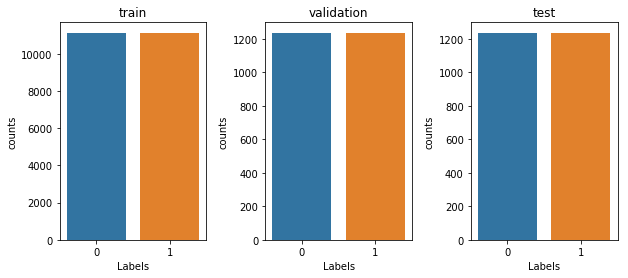

In [149]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.target.unique(),y=train.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.target.unique(),y=val.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.target.unique(),y=test.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [150]:
%%time
train_data, val_data, test_data = TabularDataset.splits(
    path='./', 
    format='csv', 
    train='train_full.csv', 
    validation='val_full.csv', 
    test='test_full.csv', 
    fields=data_fields2, 
    skip_header=True)

Wall time: 40.5 s


### 2b. Alternatively, start with a smaller set for testing purpose

In [22]:
df_small = df_final[df_final.word_count > 5].sample(3000)

In [23]:
train_val_sub, test_sub = split_train_test(df_small, df_small.target, test_size=0.2)
train_sub, val_sub = split_train_test(df_small, df_small.target, test_size=0.2)

In [24]:
train_sub.to_csv("train_sub.csv", index=False)
val_sub.to_csv("val_sub.csv", index=False)
test_sub.to_csv("test_sub.csv", index=False)

In [25]:
train_sub.shape, val_sub.shape, test_sub.shape

((2400, 7), (600, 7), (600, 7))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

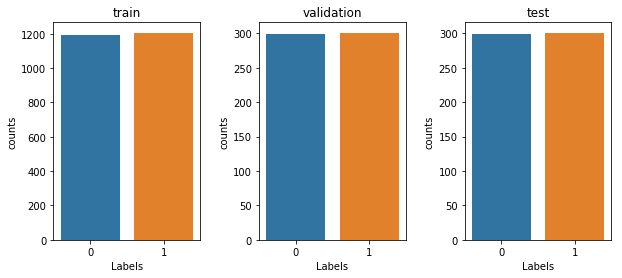

In [26]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train_sub.target.unique(),y=train_sub.target.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val_sub.target.unique(),y=val_sub.target.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test_sub.target.unique(),y=test_sub.target.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [27]:
%%time
## use additional features

train_data, val_data, test_data = TabularDataset.splits(
    path='./', 
    format='csv', 
    train='train_sub.csv', 
    validation='val_sub.csv', 
    test='test_sub.csv', 
    fields=data_fields2, 
    skip_header=True)

Wall time: 5.51 s


### 3. Build vocabulary, using glove pretrained embeddings

In [32]:
path_embed = "/Users/Susan/Documents/embeddings"

%%time
vec = torchtext.vocab.Vectors('glove.42B.300d.txt', '/Users/Susan/Documents/embeddings/glove.42B.300d')

pickle.dump(vec, open("vec.pkl", "wb"))

In [151]:
%%time
vec = pickle.load(open("vec.pkl", "rb"))

Wall time: 7.22 s


In [152]:
%%time
MAX_VOCAB_SIZE = 100_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors=vec)

TARGET.build_vocab(train_data)

Wall time: 897 ms


In [153]:
TEXT.vocab.vectors.shape

torch.Size([29714, 300])

In [154]:
TEXT.vocab.freqs.most_common(10)

[('i', 60994),
 ('the', 60335),
 ('and', 43024),
 ('a', 38919),
 ('it', 32494),
 ('to', 28761),
 ('is', 26804),
 ('not', 21181),
 ('for', 20080),
 ('this', 17507)]

In [155]:
train_data[0].__dict__.keys()

dict_keys(['year', 'overall', 'word_count', 'processedText', 'target'])

In [156]:
train_data[0].processedText[:3]

['new', 'balace', 'not']

### 4. Load data in batches

In [157]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(32, 32,32), 
                                            sort_key=lambda x: len(x.processedText), 
                                            device=None, 
                                            sort_within_batch=False, ##
                                            repeat=False)

In [158]:
len(train_loader), len(val_loader), len(test_loader)

(696, 78, 78)

In [159]:
train_loader.dataset.word_count

<generator object Dataset.__getattr__ at 0x000001A80E0EF518>

In [160]:
batch = next(iter(train_loader))
batch


[torchtext.data.batch.Batch of size 32]
	[.year]:[torch.LongTensor of size 32]
	[.overall]:[torch.LongTensor of size 32]
	[.word_count]:[torch.LongTensor of size 32]
	[.processedText]:('[torch.LongTensor of size 113x32]', '[torch.LongTensor of size 32]')
	[.target]:[torch.LongTensor of size 32]

In [161]:
batch.target

tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1])

In [162]:
batch.processedText

(tensor([[ 111,    2,   41,  ..., 9814,   30,   40],
         [  18,   39,   67,  ...,  446,  236,  121],
         [ 134,   11,    3,  ...,   37,    2,   11],
         ...,
         [  85,    1,    1,  ...,    1,    1,    1],
         [  11,    1,    1,  ...,    1,    1,    1],
         [ 157,    1,    1,  ...,    1,    1,    1]]),
 tensor([113,  62, 103,  39,  47, 110,  28,  27,  61,  47,  56, 102,  72,  30,
          98,  74,  35,  23,  28,  56,  39,  60,  80,  48,  44,  33,  71,  91,
          49,  52,  84,  22]))

In [163]:
def idxtosent(batch, idx):
    return ' '.join([TEXT.vocab.itos[i] for i in batch.processedText[0][:,idx].cpu().data.numpy()])

In [164]:
idxtosent(batch,0)

'could have been a little larger i bought another top and was happy with it but decided for some reason that i cannon remember to buy this top in white it turned out to be a lot smaller than the other top that came and i loved this top is more of that feeling of plastic where it does not have any stretch and is a lot hotter than it should be also it does not fall down as low as the other t top i bought so it does not fall below another shirt as i was hoping for its too tight too short and too uncomfortablei will not buy this again'

In [165]:
batch.__dict__

{'batch_size': 32,
 'dataset': <torchtext.data.dataset.TabularDataset at 0x1a89fe85e10>,
 'fields': dict_keys(['reviewTime', 'year', 'overall', 'word_count', 'reviewerID', 'processedText', 'target']),
 'input_fields': ['year', 'overall', 'word_count', 'processedText'],
 'target_fields': ['target'],
 'year': tensor([2014, 2013, 2011, 2013, 2013, 2013, 2013, 2014, 2014, 2013, 2013, 2014,
         2012, 2011, 2014, 2014, 2014, 2013, 2013, 2014, 2014, 2014, 2012, 2012,
         2013, 2008, 2014, 2014, 2013, 2012, 2013, 2013]),
 'overall': tensor([2, 5, 4, 3, 4, 5, 5, 5, 5, 5, 4, 4, 5, 5, 3, 4, 5, 5, 5, 4, 4, 3, 5, 5,
         5, 5, 1, 5, 3, 2, 4, 4]),
 'word_count': tensor([109,  61, 103,  39,  47, 107,  28,  27,  65,  47,  53, 100,  72,  30,
          98,  73,  35,  22,  30,  57,  35,  56,  79,  48,  42,  33,  67,  91,
          50,  52,  84,  22]),
 'processedText': (tensor([[ 111,    2,   41,  ..., 9814,   30,   40],
          [  18,   39,   67,  ...,  446,  236,  121],
          [ 134,

In [166]:
class BatchGenerator_features:
    def __init__(self, dl, x_field, year, wc, ov, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        self.year = year
        self.wc = wc
        self.ov = ov
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            year = getattr(batch, self.year)
            wc = getattr(batch, self.wc)
            ov = getattr(batch, self.ov)
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (year, wc, ov, X, y)

In [167]:
train_batch_it = BatchGenerator_features(train_loader, 'processedText', "year", "word_count", "overall", 'target')
next(iter(train_batch_it))

(tensor([2013, 2014, 2013, 2013, 2014, 2014, 2014, 2013, 2014, 2014, 2012, 2013,
         2014, 2013, 2013, 2013, 2013, 2013, 2014, 2014, 2013, 2014, 2013, 2010,
         2013, 2012, 2013, 2014, 2013, 2013, 2013, 2014]),
 tensor([ 76, 167,  28,  35,  81,  58,  64,  28,  27,  33,  41,  56,  62,  30,
         118,  42,  69,  59,  52,  99,  36,  21,  57,  26,  30,  31,  75,  23,
          26,  27, 109, 134]),
 tensor([3, 2, 4, 5, 5, 4, 1, 5, 3, 5, 3, 1, 3, 4, 2, 5, 3, 5, 3, 3, 5, 3, 4, 3,
         5, 5, 5, 3, 4, 3, 5, 5]),
 (tensor([[25998,    67,    23,  ...,    23,   187,   806],
          [   77,  1125,    44,  ...,    61,   542,  4177],
          [  586,  3021,   144,  ...,   430,   464,     2],
          ...,
          [    1,    13,     1,  ...,     1,     1,     1],
          [    1,    11,     1,  ...,     1,     1,     1],
          [    1,   159,     1,  ...,     1,     1,     1]]),
  tensor([ 77, 167,  29,  35,  86,  57,  61,  28,  27,  33,  42,  56,  62,  30,
          120,  4

In [168]:
train_loader, val_loader, test_loader = BucketIterator.splits(datasets=(train_data, val_data, test_data), 
                                            batch_sizes=(32,32,32), 
                                            sort_key=lambda x: len(x.processedText), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [169]:
len(train_loader), len(val_loader), len(test_loader)

(696, 78, 78)

In [170]:
train_batch_it = BatchGenerator_features(train_loader, 'processedText', "year", "word_count", "overall", 'target')
val_batch_it = BatchGenerator_features(val_loader, 'processedText',  "year", "word_count", "overall", 'target')
test_batch_it = BatchGenerator_features(test_loader, 'processedText', "year", "word_count", "overall", 'target')

### 5. Define Models

In [50]:
#SimpleBiGRU
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.6
recurrent_drop_out = 0.3

In [73]:
class SimpleBiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True, rec_dropout=0.1):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.bidirectional = bidirectional

        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional, dropout = rec_dropout)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        if bidirectional:
            #print("n hidden=", self.n_hidden*2)
            self.fc = nn.Linear(self.n_hidden*2+1, self.n_out)
        else:
            self.fc = nn.Linear(self.n_hidden+1, self.n_out)

        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        self.h = self.init_hidden(bs) # initialize hidden state of GRU

        embs = self.emb(seq)
        
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        
#        print("h:", self.h.shape)
#        print("gru:", gru_out.shape)
#        print("lengths:", lengths.shape)
        
#        print("h -1:",self.h[:, -1, :].shape)
        
        #hid_enc = torch.cat([self.h[0,:, :], self.h[1,:,:]], dim=1).unsqueeze(0)
        #print("hid_enc:", hid_enc.shape)
                
        
#        hid = self.h[-1]#.view(-1, 2) # self.h[-1] contains hidden state of last timestep
#        print("hid:", hid.shape)
        
        hid_bidir = torch.cat((self.h[-2], self.h[-1]), dim=1)
        #print("hid_bidir:", hid_bidir.shape)
        #print("lengths:", lengths.unsqueeze(1).shape)
        #print("concat:", torch.cat((hid_bidir, lengths.unsqueeze(1).type(torch.FloatTensor).to(device)), dim=1).shape)
        cat = torch.cat((hid_bidir, lengths.unsqueeze(1).type(torch.FloatTensor).to(device)), dim=1)
        
        hid = self.relu(cat)
        #hid = self.relu(hid_bidir)
        #cat = self.relu(cat)

        outp = self.fc(self.dropout(hid)) 
        #outp = self.fc(self.dropout(hid)) 
        
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size):
        #return Variable(torch.zeros((1,batch_size,self.n_hidden))).to(device)
        if self.bidirectional:
            return Variable(torch.zeros((2,batch_size,self.n_hidden))).to(device)
            #return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return Variable(torch.zeros((1,batch_size,self.n_hidden))).to(device)
            #return torch.zeros((1,batch_size,self.n_hidden)).to(device)    

In [62]:
#SimpleBiGRU
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.6
recurrent_drop_out = 0.3
include_features = True

In [91]:
class SimpleBiGRU_features(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True, rec_dropout=0.1, include_features=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.bidirectional = bidirectional
        self.include_features = include_features

        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)#, dropout = rec_dropout)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        if bidirectional:
            if include_features:
                self.fc = nn.Linear(self.n_hidden*2+3, self.n_out)
            else:
                self.fc = nn.Linear(self.n_hidden*2, self.n_out)
        else:
            if include_features:
                self.fc = nn.Linear(self.n_hidden+3, self.n_out)
            else:
                self.fc = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths, year, word_count, overall):
        bs = seq.size(1) # batch size
        self.h = self.init_hidden(bs) # initialize hidden state of GRU

        embs = self.emb(seq)
        
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
                                        
        hid_bidir = torch.cat((self.h[-2], self.h[-1]), dim=1)
        
        if self.include_features:
            cat = torch.cat((hid_bidir, year.unsqueeze(1).type(torch.FloatTensor).to(device),
                        word_count.unsqueeze(1).type(torch.FloatTensor).to(device),
                        overall.unsqueeze(1).type(torch.FloatTensor).to(device)
                        ), dim=1)
        else:
            cat = hid_bidir
        
        hid = self.relu(cat)
        outp = self.fc(self.dropout(hid)) 
        
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size):        
        if self.bidirectional:
            return Variable(torch.zeros((2,batch_size,self.n_hidden))).to(device)
            #return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return Variable(torch.zeros((1,batch_size,self.n_hidden))).to(device)
            #return torch.zeros((1,batch_size,self.n_hidden)).to(device)    

In [772]:
#ConcatPoolingGRUAdaptive
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.7
recurrent_drop_out = 0.2

In [119]:
class ConcatPoolingGRUAdaptive_features(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, dropout, bidirectional=True, rec_dropout=0.1, include_features=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.include_features = include_features
        #self.max_length = max_length
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)#, dropout = rec_dropout)

        if bidirectional:
            if include_features:
                self.fc = nn.Linear(self.n_hidden*2*2+3, self.n_out)
            else:
                self.fc = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            if include_features:
                self.fc = nn.Linear(self.n_hidden*2+3, self.n_out)
            else:
                self.fc = nn.Linear(self.n_hidden*2, self.n_out)            
            
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, seq, lengths, year, word_count, overall):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
                
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1) 
        
        cat_pool = torch.cat([avg_pool,max_pool],dim=1)
        
        if self.include_features:
            cat = torch.cat((cat_pool, year.unsqueeze(1).type(torch.FloatTensor).to(device),
                        word_count.unsqueeze(1).type(torch.FloatTensor).to(device),
                        overall.unsqueeze(1).type(torch.FloatTensor).to(device)
                        ), dim=1)
        else:
            cat = cat_pool
            
        cat = self.relu(cat)
            
        #cat = self.dropout(torch.cat([avg_pool,max_pool],dim=1))
        cat = self.dropout(cat)
                
        outp = self.fc(cat)
        return F.log_softmax(outp)
        #return F.softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

m.to(device)

In [53]:
len(train_loader), len(val_loader), len(test_loader)

(75, 19, 19)

### 6. Define Training and Evaluation Process

In [177]:
def train(model, iterator, optimizer, criterion, num_batch):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
  
        #t = tqdm_notebook(iterator, leave=False, total=num_batch)
        model.train()
        
        #for (X,lengths),y in iterator:
        for year, wc, overall, (X,lengths),y in iterator:

            if (lengths== 0).any():
                #print(seq)                
                #print(lengths)
                num_batch -= 1
                continue
                
            #t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()

            opt.zero_grad()

            pred = model(X, lengths, year, wc, overall)
            loss = criterion(pred, y)

            loss.backward()
            opt.step()

            #t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]

            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/num_batch
        return train_loss, train_acc

In [178]:
def evaluate(model, iterator, criterion, num_batch):
            model.eval()
            y_true_val = list()
            y_pred_val = list()
            
            total_loss_val = 0
            
            #for (X,lengths),y in iterator: #tqdm_notebook(iterator, leave=False): 
            for year, wc, overall, (X,lengths),y in iterator:                

                if (lengths== 0).any():
                    #print(seq)                
                    #print(lengths)
                    num_batch -= 1
                    continue
                pred = model(X, lengths, year, wc, overall)
                
                #pred = model(X, lengths.cpu().numpy())
                loss = criterion(pred, y)
              
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
                
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/num_batch
            return valloss, valacc

In [58]:
device

device(type='cuda', index=0)

### Create Model and Start Training - 1 - GRU with additional features

In [68]:
#SimpleBiGRU_features
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.6
recurrent_drop_out = 0.3
include_features = True

In [72]:
m = SimpleBiGRU_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 2e-4)

In [73]:
loss_fn=F.nll_loss
#epochs=50

In [74]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
model_name="GRU_features3_sub_1.pt"

In [186]:
def start_training(m, epochs, train_batch_it, val_batch_it, opt, loss_fn, model_name):
    best_valid_loss = float('inf')

    train_losses , train_accuracy = [],[]
    val_losses , val_accuracy = [],[]

    total_start_time = time.time()

    for epoch in range(epochs):      

        start_time = time.time()

        train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
        valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        val_losses.append(valid_loss)
        val_accuracy.append(valid_acc)


        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(m.state_dict(), model_name)


        print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f} | epoch_time: {epoch_mins}:{epoch_secs}')

    total_end = time.time()
    print((total_end - total_start_time)/60)   

    print("Execution Time: ", round(((total_end - total_start_time)/60),1), "minutes")
    return train_losses , train_accuracy, val_losses , val_accuracy

In [77]:
best_valid_loss = float('inf')

epochs=40

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

total_start_time = time.time()

for epoch in range(epochs):      

    start_time = time.time()
    
    train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
    valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), model_name)
          
        
    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f} | epoch_time: {epoch_mins}:{epoch_secs}')

total_end = time.time()
print((total_end - total_start_time)/60)   

print("Execution Time: ", round(((total_end - total_start_time)/60),1), "minutes")

Epoch 0: train_loss: 142.1185 train_acc: 0.5092 | val_loss: 125.1705 val_acc: 0.4983 | epoch_time: 0:1
Epoch 1: train_loss: 116.0837 train_acc: 0.4954 | val_loss: 96.5925 val_acc: 0.4983 | epoch_time: 0:1
Epoch 2: train_loss: 84.2627 train_acc: 0.5088 | val_loss: 68.7828 val_acc: 0.4983 | epoch_time: 0:1
Epoch 3: train_loss: 55.5376 train_acc: 0.4958 | val_loss: 41.3314 val_acc: 0.4983 | epoch_time: 0:1
Epoch 4: train_loss: 27.9345 train_acc: 0.5108 | val_loss: 13.3568 val_acc: 0.4983 | epoch_time: 0:1
Epoch 5: train_loss: 4.2331 train_acc: 0.5188 | val_loss: 0.6860 val_acc: 0.5383 | epoch_time: 0:1
Epoch 6: train_loss: 0.6946 train_acc: 0.5504 | val_loss: 0.7024 val_acc: 0.5150 | epoch_time: 0:1
Epoch 7: train_loss: 0.6792 train_acc: 0.5750 | val_loss: 0.6818 val_acc: 0.5683 | epoch_time: 0:1
Epoch 8: train_loss: 0.6717 train_acc: 0.5975 | val_loss: 0.6862 val_acc: 0.5417 | epoch_time: 0:1
Epoch 9: train_loss: 0.6732 train_acc: 0.5967 | val_loss: 0.6859 val_acc: 0.5700 | epoch_time: 0

In [72]:
m = SimpleBiGRU_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 2e-4)

In [79]:
model_name[:-3]

'GRU_features3_sub_1'

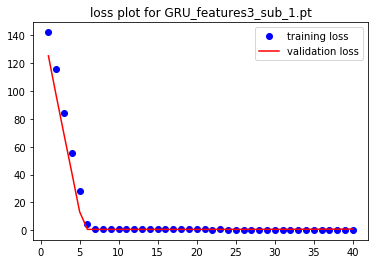

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.title("loss plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] + '_loss.png'), dpi=fig.dpi)

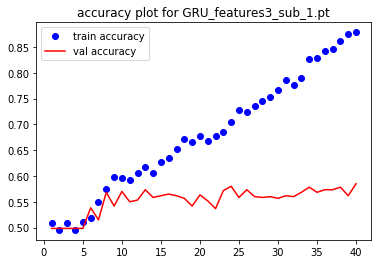

In [81]:
fig = plt.figure()
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.title("accuracy plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] +'_acc.png'), dpi=fig.dpi)

In [129]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.998 | Test Acc: 55.50%


In [82]:
m = SimpleBiGRU_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
m.load_state_dict(torch.load(model_name))
m.eval()

SimpleBiGRU_features(
  (emb): Embedding(8665, 300)
  (gru): GRU(300, 64, bidirectional=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.6)
  (fc): Linear(in_features=131, out_features=2, bias=True)
)

In [718]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out).to(device)
m.load_state_dict(torch.load(model_name))
m.eval()

ConcatPoolingGRUAdaptive(
  (emb): Embedding(8781, 300)
  (gru): GRU(300, 64, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.7)
  (relu): ReLU()
)

In [83]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.682 | Test Acc: 57.33%


### Create Model and Start Training - 2 - GRU without features

In [92]:
#SimpleBiGRU_features
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.6
recurrent_drop_out = 0.3

In [93]:
include_features = False

In [94]:
m = SimpleBiGRU_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 2e-4)

In [95]:
model_name="GRU_features_0_sub_1.pt"

In [96]:
best_valid_loss = float('inf')

epochs=40

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

total_start_time = time.time()

for epoch in range(epochs):      

    start_time = time.time()
    
    train_loss, train_acc = train(m, iter(train_batch_it), opt, loss_fn, len(train_batch_it))
    valid_loss, valid_acc = evaluate(m, iter(val_batch_it), loss_fn, len(val_batch_it))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), model_name)
          
        
    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f} | epoch_time: {epoch_mins}:{epoch_secs}')

total_end = time.time()
print((total_end - total_start_time)/60)   

print("Execution Time: ", round(((total_end - total_start_time)/60),1), "minutes")

Epoch 0: train_loss: 0.7050 train_acc: 0.4883 | val_loss: 0.6900 val_acc: 0.5333 | epoch_time: 0:1
Epoch 1: train_loss: 0.6937 train_acc: 0.5217 | val_loss: 0.6870 val_acc: 0.5467 | epoch_time: 0:1
Epoch 2: train_loss: 0.6881 train_acc: 0.5475 | val_loss: 0.6840 val_acc: 0.5483 | epoch_time: 0:1
Epoch 3: train_loss: 0.6797 train_acc: 0.5683 | val_loss: 0.6828 val_acc: 0.5583 | epoch_time: 0:1
Epoch 4: train_loss: 0.6729 train_acc: 0.5850 | val_loss: 0.6822 val_acc: 0.5517 | epoch_time: 0:1
Epoch 5: train_loss: 0.6698 train_acc: 0.5908 | val_loss: 0.6796 val_acc: 0.5550 | epoch_time: 0:1
Epoch 6: train_loss: 0.6620 train_acc: 0.6133 | val_loss: 0.6792 val_acc: 0.5633 | epoch_time: 0:1
Epoch 7: train_loss: 0.6594 train_acc: 0.6175 | val_loss: 0.6780 val_acc: 0.5650 | epoch_time: 0:1
Epoch 8: train_loss: 0.6498 train_acc: 0.6350 | val_loss: 0.6783 val_acc: 0.5567 | epoch_time: 0:1
Epoch 9: train_loss: 0.6407 train_acc: 0.6329 | val_loss: 0.6774 val_acc: 0.5650 | epoch_time: 0:1
Epoch 10: 

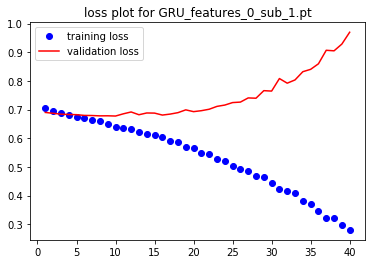

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.title("loss plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] + '_loss.png'), dpi=fig.dpi)

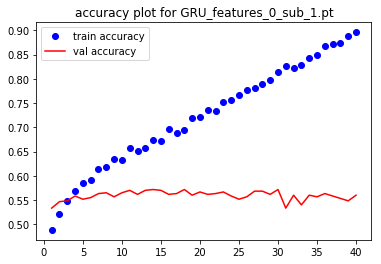

In [99]:
fig = plt.figure()
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.title("accuracy plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] +'_acc.png'), dpi=fig.dpi)

In [100]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.970 | Test Acc: 56.00%


In [101]:
m = SimpleBiGRU_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, False).to(device)
m.load_state_dict(torch.load(model_name))
m.eval()

SimpleBiGRU_features(
  (emb): Embedding(8665, 300)
  (gru): GRU(300, 64, bidirectional=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.6)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [102]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.677 | Test Acc: 56.50%


### Create Model and Start Training - 3 - Concat Pooling with additional features

In [108]:
#ConcatPoolingGRUAdaptive
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.7
recurrent_drop_out = 0.2

In [109]:
include_features = True

In [120]:
m = ConcatPoolingGRUAdaptive_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 2e-4)

In [121]:
model_name="ConcatPooling_features3_sub_1.pt"

In [122]:
epochs = 10

In [123]:
train_losses , train_accuracy, val_losses , val_accuracy = start_training(m, epochs, train_batch_it, val_batch_it, opt, loss_fn, model_name)

Epoch 0: train_loss: 27.4124 train_acc: 0.4950 | val_loss: 10.5009 val_acc: 0.4983 | epoch_time: 0:1
Epoch 1: train_loss: 3.5060 train_acc: 0.4983 | val_loss: 0.8903 val_acc: 0.4983 | epoch_time: 0:1
Epoch 2: train_loss: 0.8717 train_acc: 0.5142 | val_loss: 0.6872 val_acc: 0.5400 | epoch_time: 0:1
Epoch 3: train_loss: 0.7147 train_acc: 0.5325 | val_loss: 0.6853 val_acc: 0.5500 | epoch_time: 0:1
Epoch 4: train_loss: 0.7198 train_acc: 0.5346 | val_loss: 0.6926 val_acc: 0.5217 | epoch_time: 0:1
Epoch 5: train_loss: 0.7127 train_acc: 0.5513 | val_loss: 0.6953 val_acc: 0.5133 | epoch_time: 0:1
Epoch 6: train_loss: 0.7167 train_acc: 0.5363 | val_loss: 0.6792 val_acc: 0.5917 | epoch_time: 0:1
Epoch 7: train_loss: 0.6913 train_acc: 0.5487 | val_loss: 0.6773 val_acc: 0.5950 | epoch_time: 0:1
Epoch 8: train_loss: 0.7001 train_acc: 0.5733 | val_loss: 0.6836 val_acc: 0.5283 | epoch_time: 0:1
Epoch 9: train_loss: 0.7001 train_acc: 0.5629 | val_loss: 0.6763 val_acc: 0.6050 | epoch_time: 0:1
Epoch 10

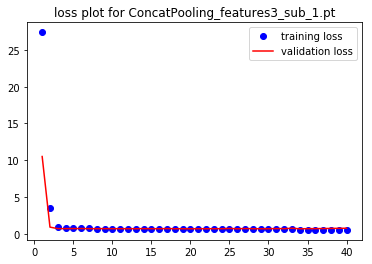

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.title("loss plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] + '_loss.png'), dpi=fig.dpi)

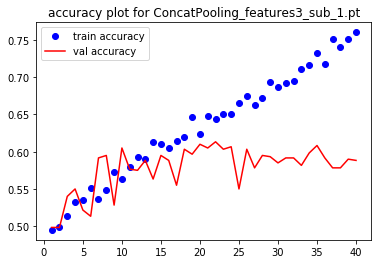

In [125]:
fig = plt.figure()
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.title("accuracy plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] +'_acc.png'), dpi=fig.dpi)

In [126]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.738 | Test Acc: 58.83%


In [127]:
m =  ConcatPoolingGRUAdaptive_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
m.load_state_dict(torch.load(model_name))
m.eval()

ConcatPoolingGRUAdaptive_features(
  (emb): Embedding(8665, 300)
  (gru): GRU(300, 64, bidirectional=True)
  (fc): Linear(in_features=259, out_features=2, bias=True)
  (dropout): Dropout(p=0.7)
  (relu): ReLU()
)

In [128]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.664 | Test Acc: 60.33%


### Create Model and Start Training - 4 - Concat Pooling with no features

In [134]:
#ConcatPoolingGRUAdaptive
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.7
recurrent_drop_out = 0.2

In [135]:
include_features = False

In [136]:
m = ConcatPoolingGRUAdaptive_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 2e-4)

In [137]:
model_name="ConcatPooling_features_0_sub_1.pt"

In [138]:
epochs = 40

In [139]:
train_losses , train_accuracy, val_losses , val_accuracy = start_training(m, epochs, train_batch_it, val_batch_it, opt, loss_fn, model_name)

Epoch 0: train_loss: 0.7093 train_acc: 0.5088 | val_loss: 0.6913 val_acc: 0.5017 | epoch_time: 0:1
Epoch 1: train_loss: 0.6971 train_acc: 0.5183 | val_loss: 0.6888 val_acc: 0.5367 | epoch_time: 0:1
Epoch 2: train_loss: 0.6855 train_acc: 0.5563 | val_loss: 0.6853 val_acc: 0.5617 | epoch_time: 0:1
Epoch 3: train_loss: 0.6883 train_acc: 0.5529 | val_loss: 0.6833 val_acc: 0.5650 | epoch_time: 0:1
Epoch 4: train_loss: 0.6812 train_acc: 0.5579 | val_loss: 0.6810 val_acc: 0.5783 | epoch_time: 0:1
Epoch 5: train_loss: 0.6754 train_acc: 0.5892 | val_loss: 0.6804 val_acc: 0.5717 | epoch_time: 0:1
Epoch 6: train_loss: 0.6725 train_acc: 0.5763 | val_loss: 0.6767 val_acc: 0.5733 | epoch_time: 0:1
Epoch 7: train_loss: 0.6643 train_acc: 0.6033 | val_loss: 0.6745 val_acc: 0.5733 | epoch_time: 0:1
Epoch 8: train_loss: 0.6603 train_acc: 0.6042 | val_loss: 0.6785 val_acc: 0.5633 | epoch_time: 0:1
Epoch 9: train_loss: 0.6499 train_acc: 0.6204 | val_loss: 0.6716 val_acc: 0.5850 | epoch_time: 0:1
Epoch 10: 

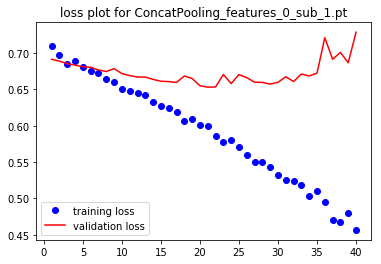

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.title("loss plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] + '_loss.png'), dpi=fig.dpi)

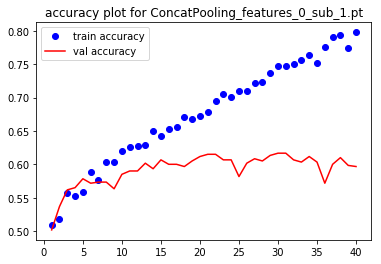

In [141]:
fig = plt.figure()
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.title("accuracy plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] +'_acc.png'), dpi=fig.dpi)

In [142]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.729 | Test Acc: 59.67%


In [143]:
m =  ConcatPoolingGRUAdaptive_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
m.load_state_dict(torch.load(model_name))
m.eval()

ConcatPoolingGRUAdaptive_features(
  (emb): Embedding(8665, 300)
  (gru): GRU(300, 64, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.7)
  (relu): ReLU()
)

In [144]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.653 | Test Acc: 61.50%


### Create Model and Start Training (full set) - 5 - Concat Pooling with additional features

In [187]:
#ConcatPoolingGRUAdaptive
vocab_size = len(TEXT.vocab)
embedding_dim = 300
n_hidden = 64
n_out = 2
drop_out = 0.7
recurrent_drop_out = 0.2

In [188]:
include_features = True

In [189]:
m = ConcatPoolingGRUAdaptive_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 5e-4)

In [190]:
model_name="ConcatPooling_features3_full_1.pt"

In [191]:
epochs = 80

In [192]:
train_losses , train_accuracy, val_losses , val_accuracy = start_training(m, epochs, train_batch_it, val_batch_it, opt, loss_fn, model_name)

Epoch 0: train_loss: 0.7790 train_acc: 0.5442 | val_loss: 0.6597 val_acc: 0.6128 | epoch_time: 0:12
Epoch 1: train_loss: 0.7265 train_acc: 0.5759 | val_loss: 0.6971 val_acc: 0.5643 | epoch_time: 0:14
Epoch 2: train_loss: 0.7322 train_acc: 0.5838 | val_loss: 0.7084 val_acc: 0.5174 | epoch_time: 0:13
Epoch 3: train_loss: 0.7162 train_acc: 0.5978 | val_loss: 0.6735 val_acc: 0.5776 | epoch_time: 0:13
Epoch 4: train_loss: 0.7251 train_acc: 0.5970 | val_loss: 0.6860 val_acc: 0.5764 | epoch_time: 0:12
Epoch 5: train_loss: 0.7110 train_acc: 0.6031 | val_loss: 0.7807 val_acc: 0.5121 | epoch_time: 0:12
Epoch 6: train_loss: 0.7151 train_acc: 0.6105 | val_loss: 0.6502 val_acc: 0.6225 | epoch_time: 0:12
Epoch 7: train_loss: 0.7039 train_acc: 0.6145 | val_loss: 0.6850 val_acc: 0.5889 | epoch_time: 0:12
Epoch 8: train_loss: 0.6906 train_acc: 0.6182 | val_loss: 0.6547 val_acc: 0.6297 | epoch_time: 0:12
Epoch 9: train_loss: 0.7167 train_acc: 0.6229 | val_loss: 0.6555 val_acc: 0.6156 | epoch_time: 0:12


In [180]:
len(train_loader), len(val_loader), len(test_loader)

(696, 78, 78)

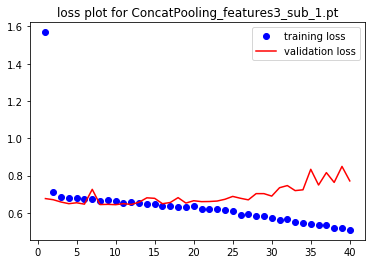

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.title("loss plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] + '_loss.png'), dpi=fig.dpi)

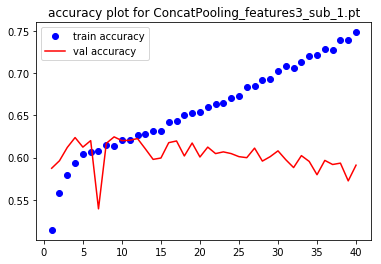

In [182]:
fig = plt.figure()
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.title("accuracy plot for " + model_name)
plt.legend()
fig.savefig(os.path.join("plots",model_name[:-3] +'_acc.png'), dpi=fig.dpi)

In [183]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.771 | Test Acc: 59.09%


In [184]:
m =  ConcatPoolingGRUAdaptive_features(vocab_size, embedding_dim, n_hidden, n_out, train_data.fields['processedText'].vocab.vectors, drop_out, True, recurrent_drop_out, include_features).to(device)
m.load_state_dict(torch.load(model_name))
m.eval()

ConcatPoolingGRUAdaptive_features(
  (emb): Embedding(29714, 300)
  (gru): GRU(300, 64, bidirectional=True)
  (fc): Linear(in_features=259, out_features=2, bias=True)
  (dropout): Dropout(p=0.7)
  (relu): ReLU()
)

In [185]:
test_loss, test_acc = evaluate(m, iter(test_batch_it), loss_fn, len(test_batch_it))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.644 | Test Acc: 62.00%
